In [280]:
%load_ext autoreload
import ais_predict.datasets.bigquery as bq
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<AxesSubplot:>

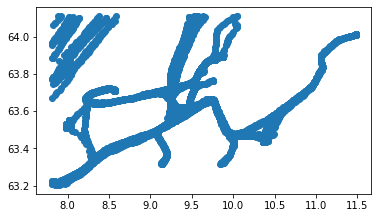

In [2]:
df = bq.download(limit=10000, lead=1)
df.position.plot()

#plt.xlim([200, 250])
#plt.ylim([25, 75])

<AxesSubplot:>

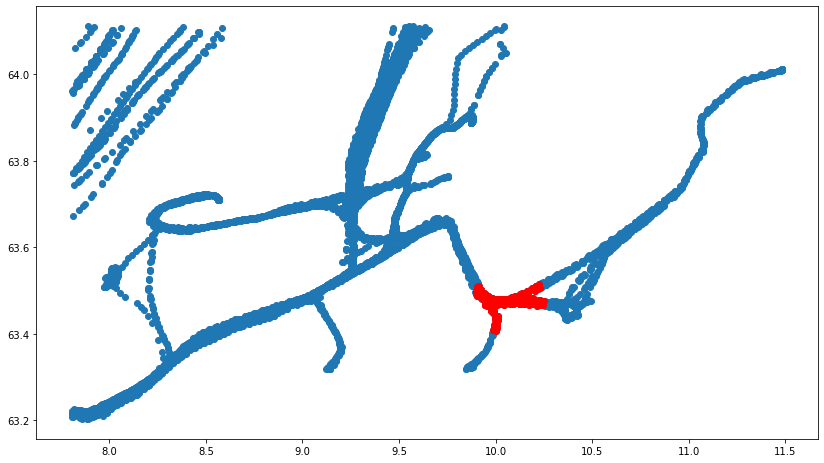

In [436]:
center = df.position.sample().to_crs(epsg=3857).to_numpy()[0]
subset = df.to_crs(epsg=3857).within(center.buffer(20e3))
ax = df.plot()
df[subset].plot(ax=ax, color="red")

In [451]:

within = gpd.GeoSeries(center.buffer(20e3, resolution=4), crs="epsg:3857").to_crs("wgs84").to_numpy()[0]
d = bq.download(lead=1, within=within, limit=1000)

<AxesSubplot:>

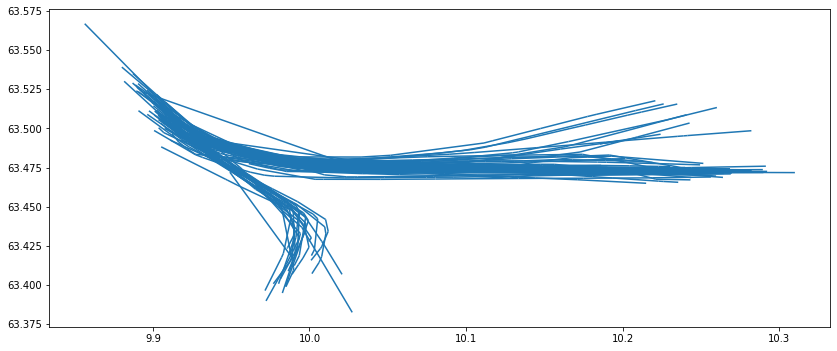

In [452]:
from shapely.geometry import Point, LineString
import geopandas as gpd

p = gpd.GeoSeries(d[["position", "position_1"]].apply(lambda x: LineString(x.tolist()), axis=1))
temp = gpd.GeoDataFrame({"lines": p, "cog": d.cog}, geometry="lines")
temp.plot()

In [453]:
%autoreload
import ais_predict.trajpred.dyngp as dyngp
import numpy as np
X, Y, dt = dyngp.samples_from_lag_1_df(d)
train_x = X[::2, :]
train_y = Y[::2, :]
train_dt = dt[::2]
test_x = X[1::2, :]
test_y = Y[1::2, :]
test_dt = dt[1::2]
m = dyngp.DynGP(train_x, train_y)

f, std = m(test_x)
np.mean(abs(f - test_y), axis=0)

array([2.91841284, 1.91192009])

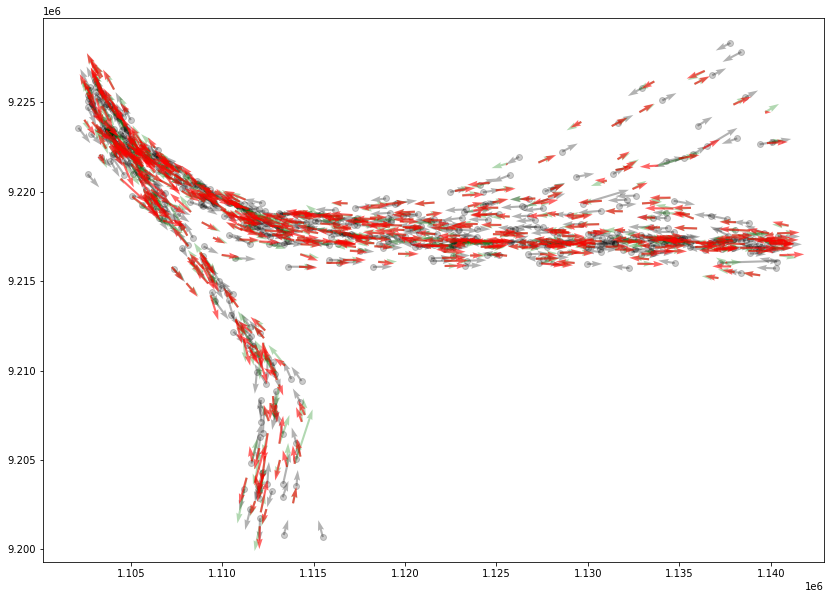

In [454]:
import matplotlib.pyplot as plt
plt.scatter(*train_x[:, :2].T, color="black", alpha=0.2)
plt.quiver(*train_x[:, :2].T, *train_y.T, color="black", alpha=0.3)
plt.quiver(*test_x[:, :2].T, *test_y.T, color="green", alpha=0.3)
plt.quiver(*test_x[:, :2].T, *f.T, color="red", alpha=0.6)